In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def cm2inch(value):
    return value/2.54

In [4]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

## Functions

In [5]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [6]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [7]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [8]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [9]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45,
                 mem_other=True, mem_total=False):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1

    df_p = pd.pivot_table(df, index=[index], values=values)

    if mem_total:
        df_mem = pd.pivot_table(df, index=[index], values=['Memory per VP'])
    elif mem_other:
        df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    else:
        df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    if mem_total:
        df_mem.plot(kind='bar', capsize=4, legend=False, ax=axes[ncols-1],
                    fontsize=fontsize_axis, rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    else:
        df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                    fontsize=fontsize_axis, rot=rot, color=['tab:purple', 'pink', 'red'])

        plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    #if not mem_total:
    axes[ncols-1].axhline(y=df['Memory per VP'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per VP')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    if not mem_total:
        df_p['connections'] = df_mem['connections']
        df_p['ini'] = df_mem['ini']
        if mem_other:
            df_p['other'] = df_mem['other']
    return df_p

In [26]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        values.insert(3, 'T_sim')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

## Benchmarks with weak scaling

### HPC Benchmark

Conn. Creation (min)          Conn. Exchange (min)           \
Case    6d8d3047 (master) NEST 3.0    6d8d3047 (master) NEST 3.0   
N_VP                                                               
36                  54.87    56.91                43.81    42.52   
72                  54.85    57.96                45.60    43.92   
144                 55.11    59.61                46.82    43.88   
288                 53.63    58.64                49.08    47.14   
576                 52.70    59.70                59.66    60.31   
1152                52.56    60.07                79.56    78.88   

           Conn. Total              Memory per VP                       T_sim  \
Case 6d8d3047 (master) NEST 3.0 6d8d3047 (master)  NEST 3.0 6d8d3047 (master)   
N_VP                                                                            
36              106.98   105.86          2.818064  2.811359            200.10   
72              105.84   106.86          2.827462  2.812945            200.28   
144             112.07   108.99          2.905892  2.898536            208.25   
288             111.14   113.16          2.911404  2.904190            214.83   
576             124.92   127.55          3.028186  3.029565            232.99   
1152            144.27   147.70          3.379609  3.374423            267.95   

               
Case NEST 3.0  
N_VP           
36     202.17  
72     204.42  
144    212.39  
288    220.78  
576    243.36  
1152   274.15

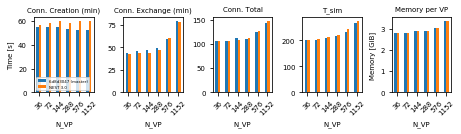

In [31]:
hpc_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint.csv')
hpc_m['Case'] = ['6d8d3047 (master)'] * len(hpc_m)
hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_daint.csv')
hpc_3['Case'] = ['NEST 3.0'] * len(hpc_m)

hpc = pd.concat([hpc_m, hpc_3])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left')

hpc_p

### Population model

Conn. Creation (min)             Conn. Exchange (min)             \
Case    6d8d3047 (master)    NEST 3.0    6d8d3047 (master)   NEST 3.0   
N_VP                                                                    
36              82.395484   68.268138            42.445847  40.569822   
72             113.637962   79.953391            42.048199  41.674768   
144            172.283743  101.281447            41.480264  41.287533   
288            296.239668  144.080008            44.489922  44.608692   
576            524.236601  234.326606            55.321616  54.913836   
1152          1025.495776  410.311771            98.690875  94.521306   

           Conn. Total                 Memory per VP            
Case 6d8d3047 (master)    NEST 3.0 6d8d3047 (master)  NEST 3.0  
N_VP                                                            
36          133.159433  118.835180          3.417058  3.452939  
72          164.163398  133.365934          3.470728  3.558691  
144         223.381136  155.097899          3.604781  3.770051  
288         352.316512  202.078788          3.515858  3.551783  
576         595.139644  303.827724          3.606819  3.560275  
1152       1151.514961  526.687053          3.588683  3.944877

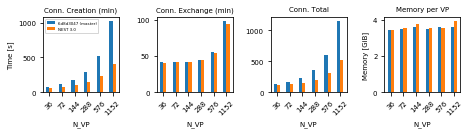

In [22]:
population_m = pd.read_csv('results/population_model_6d8d3047_daint_in.csv')
population_m['Case'] = ['6d8d3047 (master)'] * len(population_m)
population_3 = pd.read_csv('results/population_model_3_0_daint_in.csv')
population_3['Case'] = ['NEST 3.0'] * len(population_m)

population = pd.concat([population_m, population_3])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/population_model_weak_scaling.pdf',
                            plot_T_sim=False, legend_loc='upper left')

population_p

### Multi-Area Model

Conn. Creation (min)             Conn. Exchange (min)             \
Case    6d8d3047 (master)    NEST 3.0    6d8d3047 (master)   NEST 3.0   
N_VP                                                                    
36             114.422006   93.105085            32.549436  34.929152   
72             160.870316   95.895105            35.119347  40.720961   
144            244.297818         NaN            37.317799        NaN   
288            406.591223  108.697191            47.875124  43.718814   
576            733.030895  122.622003            34.746880  34.582932   
1152                  NaN         NaN                  NaN        NaN   

           Conn. Total                 Memory per VP            \
Case 6d8d3047 (master)    NEST 3.0 6d8d3047 (master)  NEST 3.0   
N_VP                                                             
36          146.971911  128.034367          2.601812  2.586323   
72          195.991162  136.616219          2.652795  2.665952   
144         281.620502         NaN          2.737491       NaN   
288         455.054129  152.416403          2.873008  2.837079   
576         767.782464  157.223816          2.782471  2.620362   
1152               NaN         NaN               NaN       NaN   

                 T_sim               
Case 6d8d3047 (master)     NEST 3.0  
N_VP                                 
36         1109.784584  1118.912730  
72         1388.385154  1418.618678  
144        1633.069055          NaN  
288        2385.635370  2158.937217  
576          65.261218    60.163940  
1152               NaN          NaN

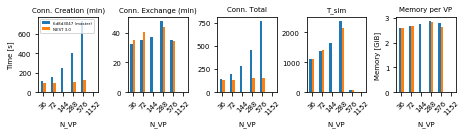

In [33]:
MAM_m = pd.read_csv('results/multi-area_model_6d8d3047_daint.csv')
MAM_m['Case'] = ['6d8d3047 (master)'] * len(MAM_m)
MAM_3 = pd.read_csv('results/multi-area_model_3_0_daint.csv')
MAM_3['Case'] = ['NEST 3.0'] * len(MAM_m)

MAM = pd.concat([MAM_m, MAM_3])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.pdf', legend_loc='upper left')

MAM_p

## Compare versions

Conn. Creation (min)                        Conn. Exchange (min)         \
Case                 2.14   2.16   2.18 8adec3cd                 2.14   2.16   
N_VP                                                                           
36                  35.65  21.84  17.56    17.43                 0.60  18.22   
72                  37.68  21.74  17.36    17.29                 0.63  18.84   
144                 39.38  21.71  17.38    17.32                 0.58  22.50   
288                 40.99  22.01  17.39    17.30                 0.67  22.05   
576                 42.90  21.77  17.39    17.38                 0.90  24.56   
1152                43.87  21.73  17.37    17.39                 1.28  29.25   

                     Conn. Total                        Memory per VP  \
Case   2.18 8adec3cd        2.14   2.16   2.18 8adec3cd          2.14   
N_VP                                                                    
36    11.78    11.84       37.39  41.12  29.69    29.57      2.312611   
72    11.78    11.46       39.99  42.98  29.81    29.34      2.327074   
144   12.36    12.31       42.03  45.60  30.39    30.19      2.707514   
288   13.03    13.12       44.44  46.59  31.11    31.17      3.149024   
576   15.09    15.48       46.74  48.86  33.61    34.08      3.144015   
1152  19.17    19.68       49.62  55.41  39.56    40.25      3.161597   

                                     T_sim                           
Case      2.16      2.18  8adec3cd    2.14    2.16    2.18 8adec3cd  
N_VP                                                                 
36    5.072531  3.096897  3.096893   82.85   88.38   90.13    89.62  
72    5.073708  3.107514  3.107514   84.19   87.63   90.85    90.32  
144   5.075892  3.109698  3.109698   87.78   92.08   95.31    94.96  
288   5.080248  3.114054  3.114054   97.88  105.33  105.49   106.58  
576   5.108859  3.578192  3.577714  110.44  119.03  128.16   128.64  
1152  5.123802  4.092529  4.092366  140.54  163.31  172.90   173.25

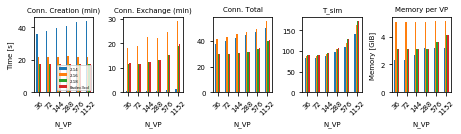

In [27]:
hpc_214 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_8adec3cd_daint_n1_s15.csv')
hpc_m['Case']   = ['8adec3cd']*len(hpc_m)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['num. nodes'] = hpc_versions['NUMBER_OF_NODES']
hpc_versions_p = plot_compare(hpc_versions, 'figures/hpc_different_versions.pdf',
                              plot_T_sim=True,
                              rot=45)
hpc_versions_p

## Benchmarks with strong scaling